In [1]:
# Прогнозирование аудитории пророком на данных из clickhouse
# https://facebook.github.io/prophet/

In [3]:
# Импортируем либы
!pip install pandahouse
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from fbprophet import Prophet

  Created wheel for pandahouse: filename=pandahouse-0.2.7-py2.py3-none-any.whl size=5920 sha256=7039886be7f8eb1632cd3627eb02cf4604cb49961c1a1061e3496e6daccb2d7b
  Stored in directory: /root/.cache/pip/wheels/a5/21/86/0baf87a3ad07ced200fa982d25162c82bb099114382cdeaa46
Successfully built pandahouse


In [4]:
# Объявляем параметры подключения к clickhouse
connection = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [5]:
# Вкидываем данные (первый столбец - даты (ds), второй - уники (y))
query = """
SELECT
    ds,
    uniqExact(DeviceID) AS y
FROM test.installs
WHERE 
        Source == 'Source_27'
    AND Platform == 'android'
GROUP BY CAST(InstallationDate AS Date) AS ds
ORDER BY ds ASC
"""
df = ph.read_clickhouse(query, connection=connection)
df['ds'] = pd.to_datetime(df.ds)
df

,ds,y
0,2019-01-01,19644
1,2019-01-02,22535
2,2019-01-03,24793
3,2019-01-04,24416
4,2019-01-05,24750
...,...,...
272,2019-09-30,13986
273,2019-10-01,13976
274,2019-10-02,13830
275,2019-10-03,13453


In [6]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2019-01-01,Новый год
1,2019-01-02,Новый год
2,2019-01-03,Новый год
3,2019-01-04,Новый год
4,2019-01-05,Новый год
5,2019-01-06,Новый год
6,2019-01-07,Православное Рождество
7,2019-01-08,Новый год
8,2019-02-23,День защитника отечества
9,2019-03-08,День женщин


In [7]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[:-predictions]

In [8]:
# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [9]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

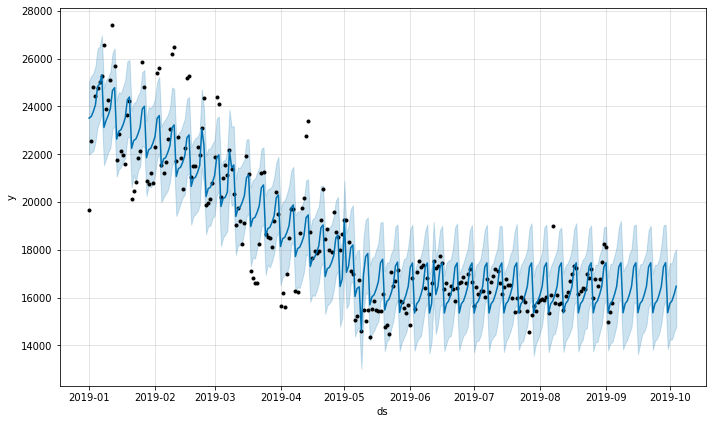

In [10]:
# Смотрим, что предсказалось
m.plot(forecast);

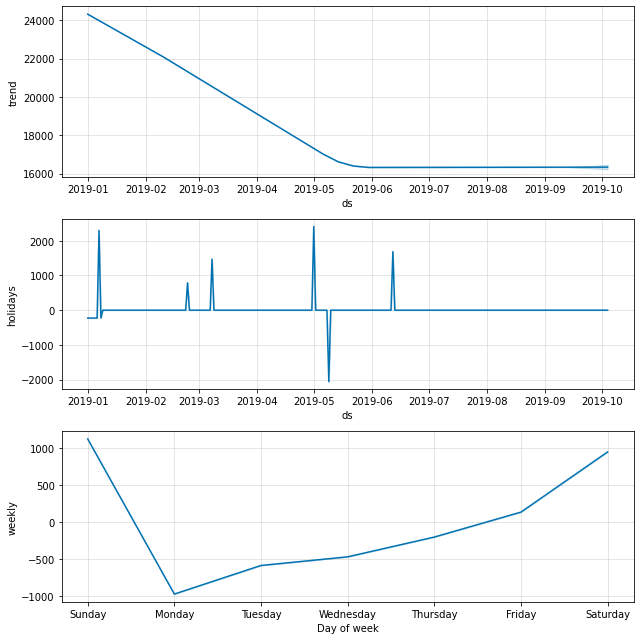

In [11]:
# Смотрим на сезонности
m.plot_components(forecast);

In [12]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [13]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  8.983907809163886 %
MAE (средняя абсолютная ошибка) –  1314.9213159944275


In [14]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 90
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

In [15]:
final_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,День Победы,День Победы_lower,День Победы_upper,День России,День России_lower,День России_upper,День женщин,День женщин_lower,День женщин_upper,День защитника отечества,День защитника отечества_lower,День защитника отечества_upper,День народного единства,День народного единства_lower,День народного единства_upper,Новый год,Новый год_lower,Новый год_upper,Православное Рождество,Православное Рождество_lower,Православное Рождество_upper,Праздник Весны и Труда,Праздник Весны и Труда_lower,Праздник Весны и Труда_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,24428.790324,21892.947644,25003.966486,24428.790324,24428.790324,-955.471416,-955.471416,-955.471416,-369.560077,-369.560077,-369.560077,-585.911339,-585.911339,-585.911339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-369.560077,-369.560077,-369.560077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23473.318908
1,2019-01-02,24370.047917,22033.054546,25107.817391,24370.047917,24370.047917,-834.751947,-834.751947,-834.751947,-369.560077,-369.560077,-369.560077,-465.191870,-465.191870,-465.191870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-369.560077,-369.560077,-369.560077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23535.295970
2,2019-01-03,24311.305511,22160.667728,25239.887905,24311.305511,24311.305511,-624.571833,-624.571833,-624.571833,-369.560077,-369.560077,-369.560077,-255.011756,-255.011756,-255.011756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-369.560077,-369.560077,-369.560077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23686.733678
3,2019-01-04,24252.563104,22518.722135,25496.652425,24252.563104,24252.563104,-270.334552,-270.334552,-270.334552,-369.560077,-369.560077,-369.560077,99.225525,99.225525,99.225525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-369.560077,-369.560077,-369.560077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23982.228552
4,2019-01-05,24193.820698,23259.146569,26478.772887,24193.820698,24193.820698,608.712697,608.712697,608.712697,-369.560077,-369.560077,-369.560077,978.272774,978.272774,978.272774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-369.560077,-369.560077,-369.560077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24802.533395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2019-12-29,14326.594530,13863.322343,17211.962520,13771.947887,14846.173123,1175.165531,1175.165531,1175.165531,0.000000,0.000000,0.000000,1175.165531,1175.165531,1175.165531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15501.760061
363,2019-12-30,14315.012523,11719.176236,15157.869524,13749.931426,14849.291021,-946.548865,-946.548865,-946.548865,0.000000,0.000000,0.000000,-946.548865,-946.548865,-946.548865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13368.463659
364,2019-12-31,14303.430516,12017.352867,15445.287617,13729.399239,14848.333445,-585.911339,-585.911339,-585.911339,0.000000,0.000000,0.000000,-585.911339,-585.911339,-585.911339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13717.519177
365,2020-01-01,14291.848509,11780.708464,15089.988785,13709.472486,14850.133236,-834.751947,-834.751947,-834.751947,-369.560077,-369.560077,-369.560077,-465.191870,-465.191870,-465.191870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-369.560077,-369.560077,-369.560077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13457.096562


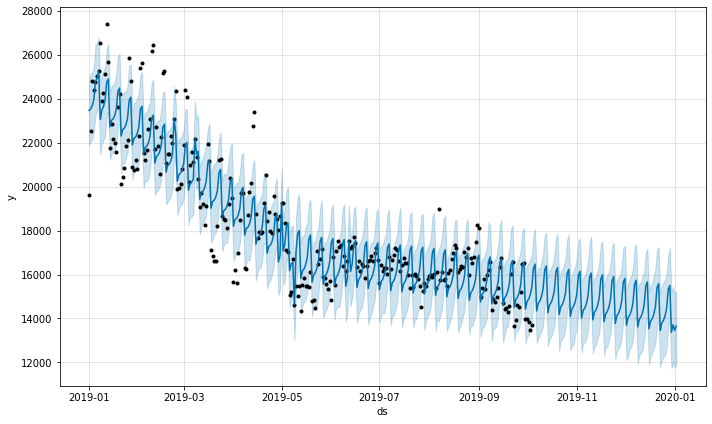

In [16]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [17]:
# Рисуем график с границами прогноза на полном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [ ]:
# Выгружаем прогноз в эксельку. Спрогнозированное значение лежит в столбце yhat
final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")